## Automated Machine Learning
We will be working with [Heart Failure Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

### Libraries
- [HyperOpt](https://hyperopt.github.io/hyperopt/) ([Tutorial 1](https://towardsdatascience.com/optimise-your-hyperparameter-tuning-with-hyperopt-861573239eb5), [Tutorial 2](https://medium.com/vooban-ai/hyperopt-tutorial-for-optimizing-neural-networks-hyperparameters-e3102814b919))


### Instructions
1. Choose a dataset. Build and train a baseline for comparison. Try a set of possible machine learning algorithms (13 algorithms) using their default hyperparamters and choose the one with the highest performance for comparison.

2. Based on the problem at hand, you study the potential pipeline structure,
algorithms or feature transformers at each step, hyper-parameters ranges. Use
hyperOpt with the potential search space to beat the baseline.

3. Monitor the performance of you the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.

4. Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

### Data
- Binary columns: Sex, ExerciseAngina
- Categorical columns: ChestPainType, RestingECG, ST_Slope

## TODO:

- [ ] Implement one hot encoding for certain algorithms.
- [ ] Fix and improve search spaces.
- [ ] Implement hyperparameter optimization for all agorithms.
- [ ] Visualise hyperparameter search.
- [ ] Compare models for statistical significance.
- [ ] Find minimum time budget for which baseline is outperformed

In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sn
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./heart_failure.csv')
df.sample(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
558,58,M,NAP,137,232,0,ST,124,Y,1.4,Flat,1
821,60,F,NAP,102,318,0,Normal,160,N,0.0,Up,0
836,65,M,ASY,135,254,0,LVH,127,N,2.8,Flat,1


In [3]:
from sklearn.preprocessing import LabelEncoder
from util import category_columns

le = LabelEncoder()
for column in ['Sex', 'ExerciseAngina']:
    df[column] = le.fit_transform(df[column])

In [4]:
from sklearn.model_selection import train_test_split
from util import find_baseline

train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)
scores = find_baseline(train_df)

In [5]:
for name, score in sorted(scores.items(), key=lambda t: t[1], reverse=True):
    print(f'{name:20}: {score:.3f}')

Logistic Regression : 0.852
Gradient Boosting   : 0.849
AdaBoost            : 0.846
LDA                 : 0.846
SVM                 : 0.842
Naive Bayes         : 0.839
Random Forest       : 0.831
Neural Network      : 0.828
Bagging Classifier  : 0.816
Decision Tree       : 0.808
Gaussian Process    : 0.750
KNN                 : 0.714
QDA                 : 0.528


In [6]:
baseline_name = max(scores, key=scores.get)
baseline_score = scores[baseline_name]
print(f"Baseline model is {baseline_name} with K-Fold score on training set: {baseline_score:.3f}")

Baseline model is Logistic Regression with K-Fold score on training set: 0.852


In [7]:
import time
from util import optimize_hyperparams, classifiers
from pprint import pprint

optimization_results = {}

for classifier in classifiers:
    print(f'{classifier}:')

    n_evals = 1000  
    max_evals = {
        'Ada Boost': n_evals/5,
        'Gaussian Process': n_evals/50,
        #'Random Forest': n_evals/10,
    }

    start_time = time.time()
    best_params, losses, params, statuses = optimize_hyperparams(classifier, train_df, max_evals.get(classifier, n_evals), True)
    elapsed = time.time() - start_time

    optimization_results[classifier] = {
        'best': best_params,
        'losses': losses,
        'statuses': statuses,
        'params': params,
        'time': elapsed,
    }

    print(f'Elapsed time: {elapsed:.2f}s')
    pprint(best_params)

KNN:
100%|██████████| 1000/1000 [01:01<00:00, 16.26trial/s, best loss: 0.2617886178861789]
Elapsed time: 61.69s
{'algorithm': 'ball_tree',
 'leaf_size': 13,
 'n_jobs': -1,
 'n_neighbors': 6,
 'p': 1,
 'weights': 'distance'}
SVM:
100%|██████████| 1000/1000 [00:53<00:00, 18.72trial/s, best loss: 0.27642276422764234]
Elapsed time: 53.58s
{'C': 0.9998291674498523,
 'break_ties': True,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': 1000}
Gaussian Process:
100%|██████████| 20/20.0 [04:36<00:00, 13.84s/trial, best loss: 0.15609756097560967]
Elapsed time: 276.86s
{'kernel': 1**2 * RBF(length_scale=1),
 'max_iter_predict': 250,
 'n_jobs': -1,
 'n_restarts_optimizer': 4,
 'warm_start': False}
Decision Tree:
100%|██████████| 1000/1000 [00:28<00:00, 35.43trial/s, best loss: 0.16747967479674808]
Elapsed time: 28.37s
{'criterion': 'log_loss',
 'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}
Random Forest:
100%|██████████| 1000/1000 [08:00<00:00,  2.08trial

In [8]:
scores = [ (name, 1 - min(result['losses'])) for name, result in optimization_results.items() ]

for name, score in sorted(scores, key=lambda x: x[1], reverse=True):
    print(f'{name:20}: {score:.3f}')

Bagging Classifier  : 0.977
Gradient Boosting   : 0.867
QDA                 : 0.862
AdaBoost            : 0.860
Random Forest       : 0.857
Neural Network      : 0.855
Logistic Regression : 0.854
LDA                 : 0.849
Gaussian Process    : 0.844
Naive Bayes         : 0.839
Decision Tree       : 0.833
KNN                 : 0.738
SVM                 : 0.724


In [9]:
from util import compare_with_baseline

baseline_score, results = compare_with_baseline(baseline_name, optimization_results, train_df, test_df)

In [18]:
from util import find_min_budget

find_min_budget(baseline_name, train_df, test_df, optimization_results)

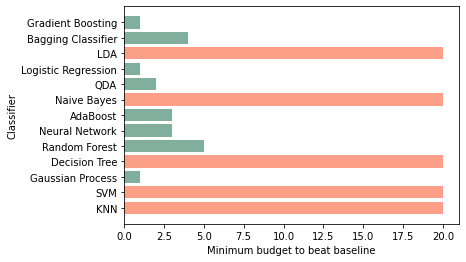

In [32]:
from matplotlib import pyplot as plt

x_lim = 20

labels = []
min_budgets = []
colors = []

for name in  optimization_results:
    labels.append(name)
    budget = min(optimization_results[name]['min_budget'], x_lim)
    min_budgets.append(budget)

    color = '#FB9F89' if optimization_results[name]['min_budget'] == len(optimization_results[name]['losses']) else '#81AE9D'
    colors.append(color)

plt.barh(labels, min_budgets, color=colors)
plt.xlabel("Minimum budget to beat baseline")
plt.ylabel("Classifier")
plt.show()

In [34]:
final_results = pd.DataFrame(columns=['Classifier', 'Minimum Budget', 'Score', 'p-value'])

final_results['Score'] = [ value['score'] for _, value in results.items()]
final_results['p-value'] = [ value['p_value'] for _, value in results.items()]

min_budgets = []
scores = []
p_values = []

for name in classifiers:
    min_budgets.append(optimization_results[name]['min_budget'])
    scores.append(round(results[name]['score'], 3))
    p_values.append(round(results[name]['p_value'], 3))


final_results['Classifier'] = [ name for name in classifiers ]
final_results['Minimum Budget'] = min_budgets
final_results['Score'] = scores
final_results['p-value'] = p_values

print(f'Baseline model is {baseline_name} with score: {baseline_score:.3f}')

# Display 
final_results.sort_values('Score', ascending=False, inplace=True)
final_results.reset_index(drop=True, inplace=True)
final_results

Baseline model is Logistic Regression with score: 0.871


,Classifier,Minimum Budget,Score,p-value
0,QDA,2,0.891,0.033
1,Gaussian Process,1,0.881,0.020
2,Logistic Regression,1,0.875,0.317
3,AdaBoost,3,0.871,1.000
4,Bagging Classifier,4,0.871,0.371
5,Naive Bayes,1000,0.868,0.513
6,LDA,1000,0.868,0.564
7,Gradient Boosting,1,0.868,0.549
8,Random Forest,5,0.858,0.670
9,Decision Tree,1000,0.802,0.000


In [35]:
from matplotlib import pyplot as plt

def visualise_search(losses, baseline, best_index):
    baseline = 1 - baseline
    plt.plot(range(len(losses)), losses, linewidth=0.8, alpha=0.5)
    plt.plot([0, len(losses)], [baseline, baseline], linestyle='dashed', linewidth=0.5, color='red', alpha=0.8)
    plt.ylim(0, 0.2)
    plt.show()